In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

In [30]:
df_month_data = pd.read_csv("Cst_to_U_Sorted.csv",index_col=False,encoding="utf-8")
alpha = 0.5
destination = 'Uppsala c' 

In [31]:
def plot_adjacency_matrix(adj_matrix, station_names):
    """
    Plot the adjacency matrix using seaborn heatmap.
    
    Parameters:
    adj_matrix (numpy.ndarray): The adjacency matrix
    station_names (list): List of station names
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(adj_matrix, cmap='Blues', 
                xticklabels=station_names, 
                yticklabels=station_names,
                linewidths=0.5,
                linecolor='lightgray')
    plt.title('Station Connectivity Adjacency Matrix')
    plt.xlabel('To Station')
    plt.ylabel('From Station')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [32]:
def create_adjacency_matrix(df):
    # Extract all stations except the destination station
    all_departure_stations = set(df['Avgångsplats'])
    all_arrival_stations = set(df['Ankomstplats'])
    
    # Combine all stations and remove destination station if specified
    all_stations = list(all_departure_stations.union(all_arrival_stations))
    
    # Create empty adjacency matrix
    n = len(all_stations)
    init_matrix = np.full((n, n), 0)
    adj_matrix = pd.DataFrame(init_matrix,
                              index=all_stations, columns=all_stations)
    
    # Fill adjacency matrix
    for _, row in df.iterrows():
        dep_station = row['Avgångsplats']
        arr_station = row['Ankomstplats']
        
        # Mark connection between departure and arrival stations
        if dep_station in all_stations and arr_station in all_stations:
            adj_matrix.loc[dep_station, arr_station] = 1
    
    return adj_matrix,all_stations

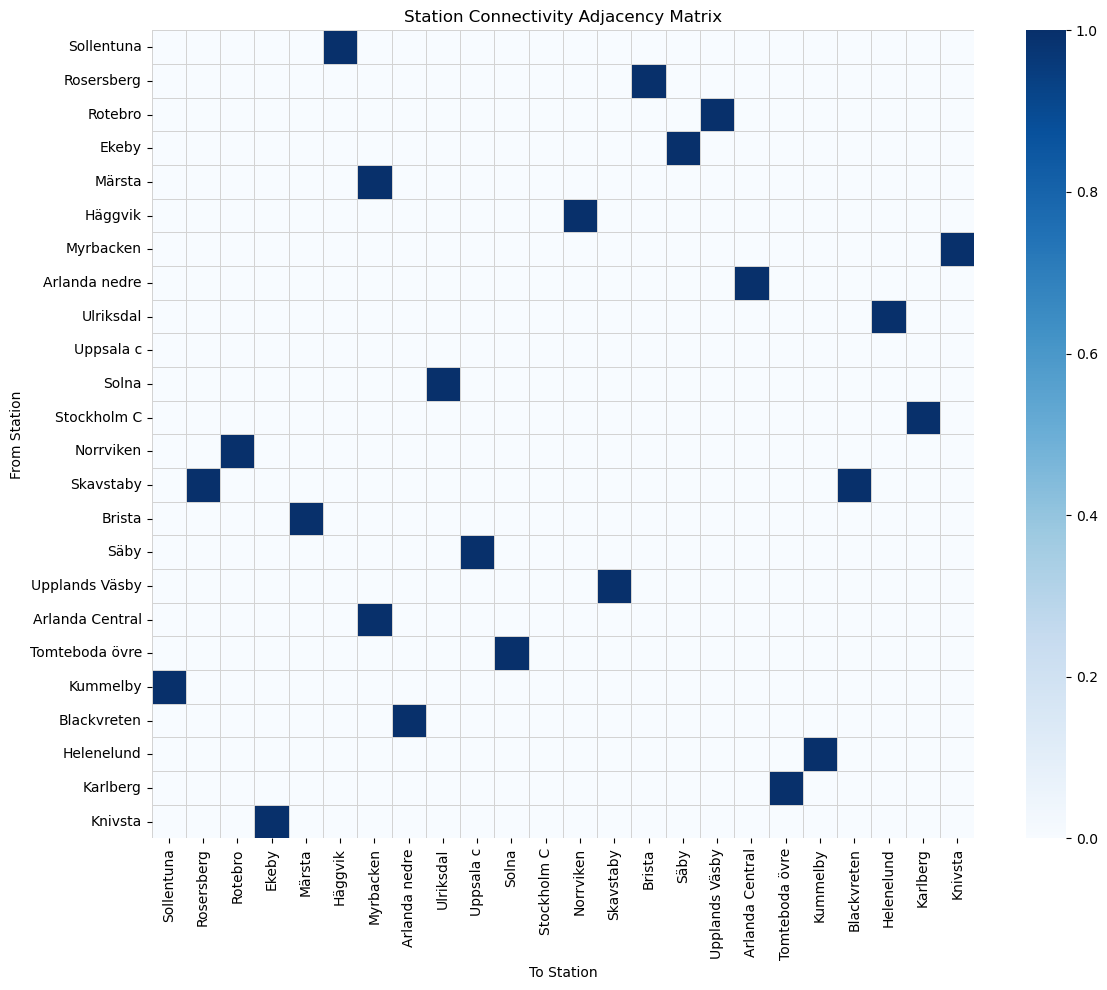

In [33]:
adj_max, all_stations = create_adjacency_matrix(df_month_data)
plot_adjacency_matrix(adj_max, all_stations)

In [34]:
# no_of_rows = (df_month_data==1).sum().sum()
# init_matrix = np.full((4, no_of_rows), 0)
# adj_matrix = pd.DataFrame(init_matrix, columns=["Arrival", "Departure", "CVAR", "VAR"])
arrival = []
departure = []
vars = []
cvars = []
route = []

for i, stationi in enumerate(all_stations):
        for j, stationj in enumerate(all_stations):
            if adj_max.loc[stationi, stationj] == 1:
                delays = df_month_data[
                    (df_month_data['Avgångsplats'] == stationi) & 
                    (df_month_data['Ankomstplats'] == stationj)
                ]['AvgFörsening'].dropna()
                
                delays = delays[delays >= 0]
                arrival.append(stationi)
                departure.append(stationj)
                route.append(f"{stationi} -> {stationj}")
                
                if not delays.empty:
                    var = np.quantile(delays, alpha)
                    tail = delays[delays >= var]
                    cvar = tail.mean() if not tail.empty else 0
                    adj_max.loc[stationi, stationj] = cvar
                    cvars.append(cvar)
                    vars.append(var)

C:\Users\kalan\AppData\Local\Temp\ipykernel_22900\2023677206.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9769452449567724' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  adj_max.loc[stationi, stationj] = cvar
C:\Users\kalan\AppData\Local\Temp\ipykernel_22900\2023677206.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.763513513513513' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  adj_max.loc[stationi, stationj] = cvar
C:\Users\kalan\AppData\Local\Temp\ipykernel_22900\2023677206.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.815789473684211' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  adj_ma

In [35]:
df = pd.DataFrame(columns=['Arrival', 'Departure', 'CVAR', 'VAR'])

# Or, with some sample data:
data = {
    'Arrival': arrival,
    'Departure': departure,
    'CVAR': cvars,
    'VAR': vars,
    'Route': route
}

df = pd.DataFrame(data)

print(df)

            Arrival        Departure      CVAR  VAR  \
0        Sollentuna          Häggvik  1.976945  0.0   
1        Rosersberg           Brista  4.763514  1.0   
2           Rotebro   Upplands Väsby  5.815789  1.0   
3             Ekeby             Säby  4.694268  1.0   
4            Märsta        Myrbacken  1.817444  0.0   
5           Häggvik        Norrviken  2.091195  0.0   
6         Myrbacken          Knivsta  4.272031  1.0   
7     Arlanda nedre  Arlanda Central  3.169811  1.0   
8         Ulriksdal       Helenelund  2.517094  0.0   
9             Solna        Ulriksdal  1.936306  0.0   
10      Stockholm C         Karlberg  2.705556  0.0   
11        Norrviken          Rotebro  5.634783  1.0   
12        Skavstaby       Rosersberg  2.010204  0.0   
13        Skavstaby      Blackvreten  1.753425  0.0   
14           Brista           Märsta  4.949275  1.0   
15             Säby        Uppsala c  4.549738  1.0   
16   Upplands Väsby        Skavstaby  2.462963  0.0   
17  Arland

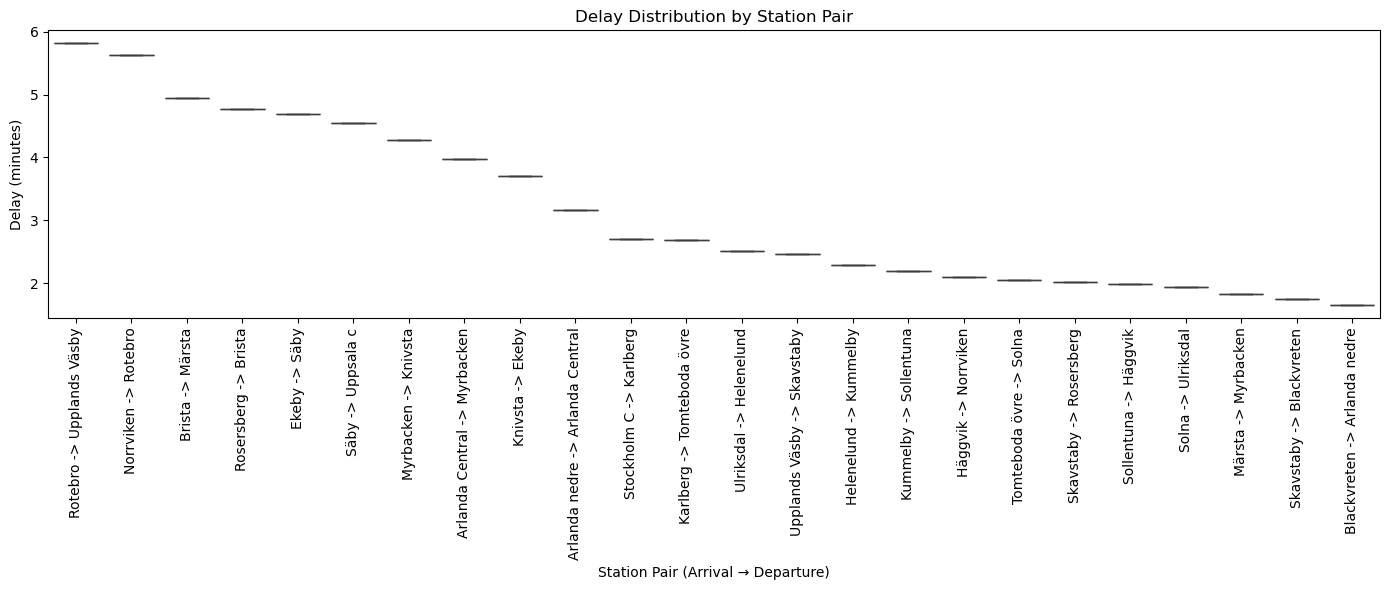

In [36]:
route_order = df.groupby('Route')['CVAR'].mean().sort_values(ascending=False).index

# Plot: boxplot of delays per route
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Route', y='CVAR', order=route_order)

plt.xticks(rotation=90)
plt.title("Delay Distribution by Station Pair")
plt.xlabel("Station Pair (Arrival → Departure)")
plt.ylabel("Delay (minutes)")
plt.tight_layout()
plt.show()

C:\Users\kalan\AppData\Local\Temp\ipykernel_22900\89169865.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delay_stats, x='Route', y='CVAR', palette='viridis')


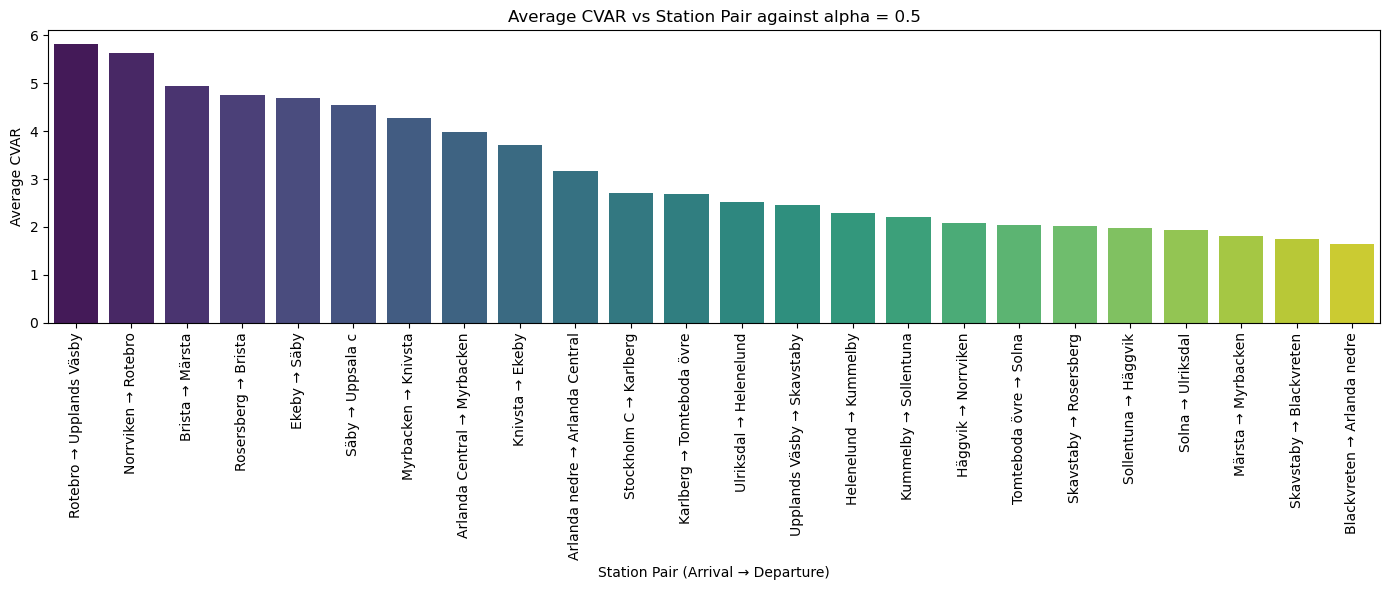

In [37]:
delay_stats = df.groupby(['Arrival', 'Departure'])['CVAR'].mean().reset_index()
delay_stats['Route'] = delay_stats['Arrival'] + " → " + delay_stats['Departure']

# Sort by delay
delay_stats = delay_stats.sort_values('CVAR', ascending=False)

# Plot barplot
plt.figure(figsize=(14, 6))
sns.barplot(data=delay_stats, x='Route', y='CVAR', palette='viridis')

plt.xticks(rotation=90)
title = "Average CVAR vs Station Pair against alpha = " + str(alpha)
plt.title(title)
plt.xlabel("Station Pair (Arrival → Departure)")
plt.ylabel("Average CVAR")
plt.tight_layout()
plt.show()